In [15]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

In [6]:
wind_table = Table.read('wind_data.ecsv').to_pandas()
shake_table = Table.read('wind_shake.ecsv').to_pandas()
exposure_table = Table.read('exposure_data.ecsv').to_pandas()

In [3]:
wind_table[:2], len(wind_table)

(<Table length=2>
        MJD             TIMESTAMP      WIND_SPEED WIND_DIRECTION   GUST 
      float64         datetime64[s]     float32      float32     float32
 ----------------- ------------------- ---------- -------------- -------
 58569.13104166667 2019-03-27T03:08:42       17.2          168.0    99.3
 58569.13247685185 2019-03-27T03:10:46       14.3          175.7    99.3,
 1036477)

In [20]:
shake_table[:2]

MJD,TIMESTAMP,WIND_GUST,WIND_SHAKE
float64,datetime64[s],int64,int64
59307.12907407407,2021-04-03T03:05:52,1,0
59307.129212962966,2021-04-03T03:06:04,1,1


In [21]:
exposure_table[:2]

EXPID,MJD,TIMESTAMP,SURVEY,PROGRAM,MOUNT_EL,MOUNT_AZ
int64,float64,datetime64[us],str7,str6,float64,float64
90224,59364.148239,2021-05-30T03:33:27.849600,sv3,BACKUP,81.25055,143.299106
90225,59364.154715,2021-05-30T03:42:47.376000,sv3,BRIGHT,56.109587,201.243202


Wind direction range: 0.0 to 359.0
Converted radians range: 0.0 to 6.2657318115234375


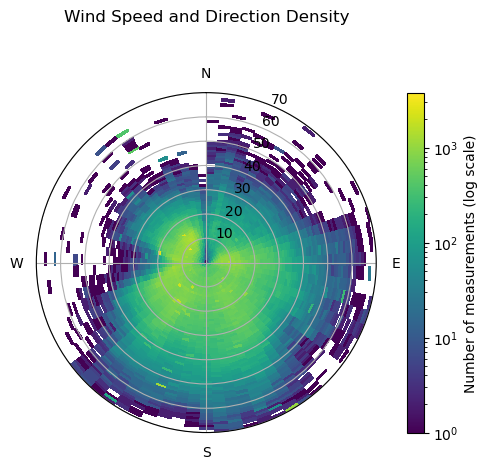

In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Convert degrees to radians for the plot
wind_dirs_rad = np.deg2rad(wind_table['WIND_DIRECTION'])

# Print some diagnostic information
print("Wind direction range:", wind_table['WIND_DIRECTION'].min(), "to", wind_table['WIND_DIRECTION'].max())
print("Converted radians range:", wind_dirs_rad.min(), "to", wind_dirs_rad.max())

# Create bins for both dimensions
rbins = np.linspace(0, 70, 70)  # 50 bins from 0 to 50 mph
# Make sure we cover the full circle
abins = np.linspace(0, 2*np.pi, 72)  # 72 bins for 360 degrees (5 degree resolution)

# Calculate the 2D histogram
hist, _, _ = np.histogram2d(wind_dirs_rad % (2*np.pi), wind_table['WIND_SPEED'], 
                          bins=[abins, rbins])

# Create a meshgrid for plotting
A, R = np.meshgrid(abins[:-1] + np.diff(abins)/2, rbins[:-1] + np.diff(rbins)/2)

# Plot the density using pcolormesh with log scale
mesh = ax.pcolormesh(A, R, hist.T, 
                    norm=LogNorm(vmin=1, vmax=hist.max()),
                    cmap='viridis')

# Customize the plot
ax.set_theta_direction(-1)  # Make it clockwise
ax.set_theta_zero_location('N')  # Set 0 degrees to North
ax.set_rmax(70)  # Set radial limit

# Add cardinal direction labels
ax.set_thetagrids([0, 90, 180, 270], labels=['N', 'E', 'S', 'W'])

# Add colorbar with log scale
cbar = plt.colorbar(mesh, label='Number of measurements (log scale)')

# Add title and adjust layout
plt.title('Wind Speed and Direction Density\n', pad=20)
fig.tight_layout()

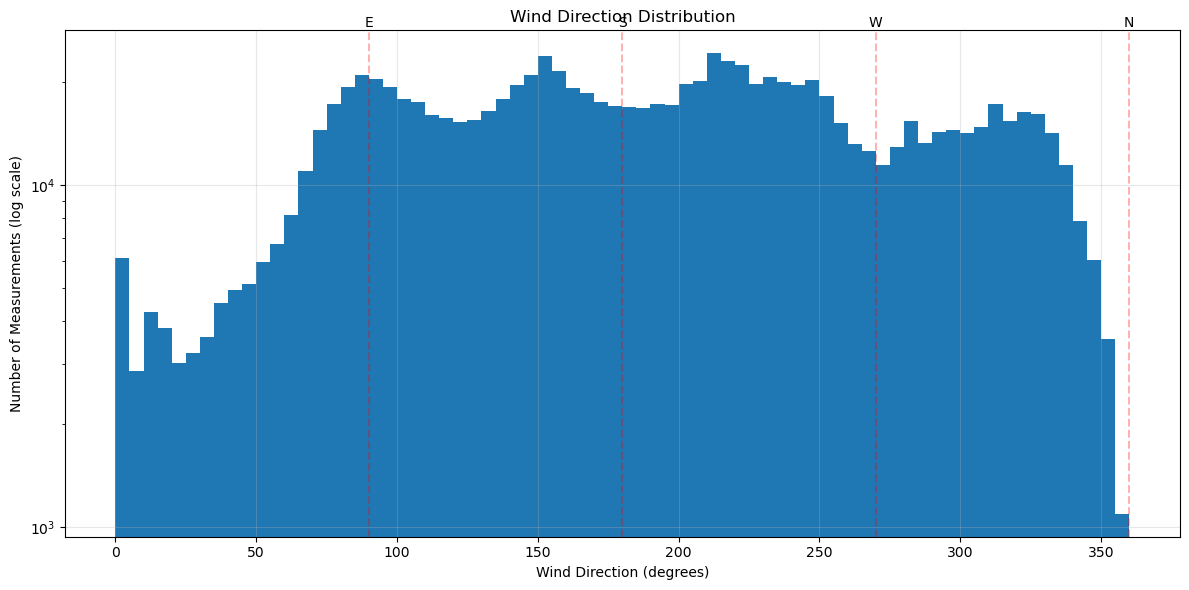

In [21]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create histogram with 72 bins (5 degree resolution)
# Same as we used in the polar plot for consistency
bins = np.linspace(0, 360, 73)  # 73 bins edges to get 72 bins
hist, bin_edges = np.histogram(wind_table['WIND_DIRECTION'], bins=bins)

# Plot histogram with log scale on y-axis
plt.hist(wind_table['WIND_DIRECTION'], bins=bins, log=True)

# Customize the plot
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Number of Measurements (log scale)')
plt.title('Wind Direction Distribution')

# Add gridlines
plt.grid(True, alpha=0.3)

# Add cardinal direction markers
cardinal_dirs = {'N': 0, 'E': 90, 'S': 180, 'W': 270, 'N': 360}
for direction, angle in cardinal_dirs.items():
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.3)
    plt.text(angle, plt.ylim()[1], direction, ha='center', va='bottom')

plt.tight_layout()

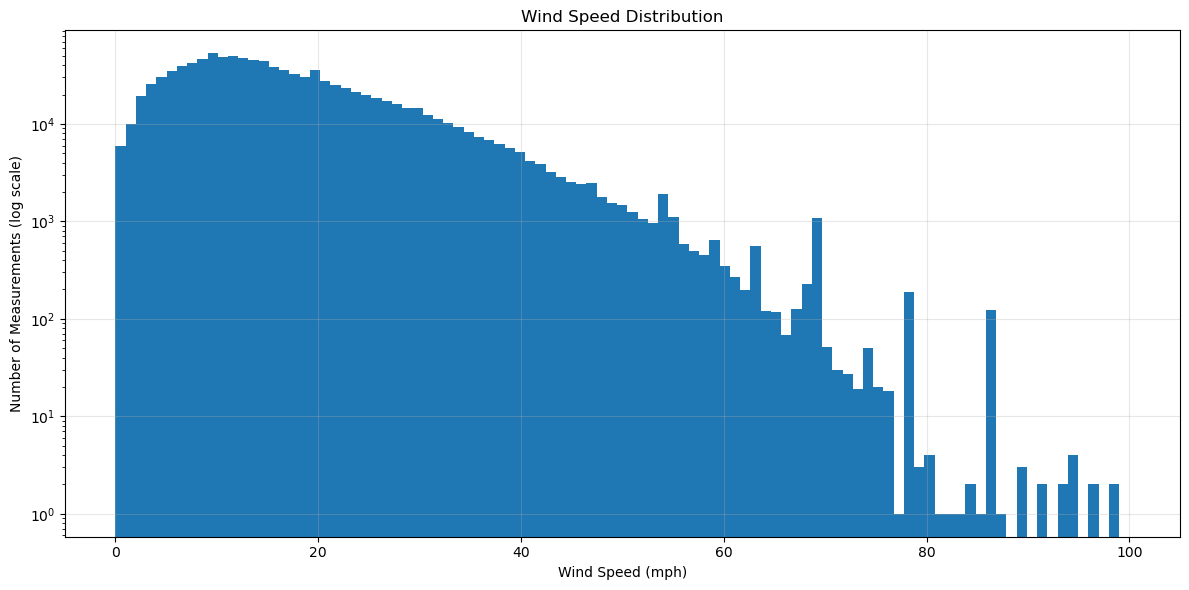

In [26]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create histogram with 72 bins (5 degree resolution)
# Same as we used in the polar plot for consistency
bins = np.linspace(0, 100, 100)  # 73 bins edges to get 72 bins
hist, bin_edges = np.histogram(wind_table['WIND_SPEED'], bins=bins)

# Plot histogram with log scale on y-axis
plt.hist(wind_table['WIND_SPEED'], bins=bins, log=True)

# Customize the plot
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Number of Measurements (log scale)')
plt.title('Wind Speed Distribution')

# Add gridlines
plt.grid(True, alpha=0.3)

# Add cardinal direction markers
#cardinal_dirs = {'N': 0, 'E': 90, 'S': 180, 'W': 270, 'N': 360}
#for direction, angle in cardinal_dirs.items():
#    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.3)
#    plt.text(angle, plt.ylim()[1], direction, ha='center', va='bottom')

plt.tight_layout()

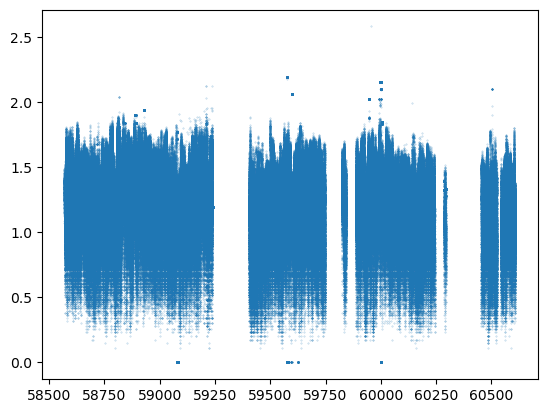

In [28]:
plt.scatter(wind_table['MJD'], np.log10(wind_table['WIND_SPEED']+1), s=0.1, alpha=0.4)

/tmp/ipykernel_1792442/1793493913.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(wind_table['MJD'], np.log10(wind_table['GUST']), s=0.1, alpha=0.4)


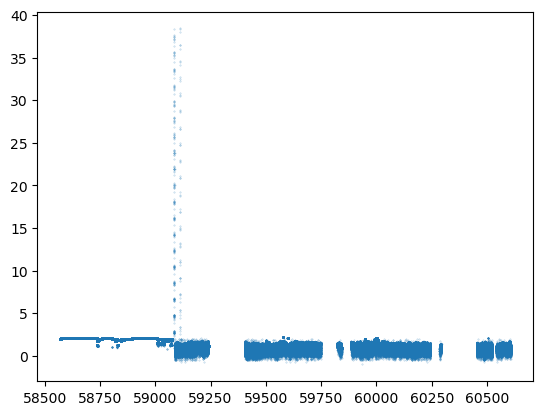

In [26]:
plt.scatter(wind_table['MJD'], np.log10(wind_table['GUST']), s=0.1, alpha=0.4)

In [ ]:
plt.scatter(wind_table['MJD'], np.log10(wind_table['WIND_SPEED']), s=0.1, alpha=0.4)
plt.scatter(exposure_table['MJD'], exposure_table['EXPID']/exposure_table['EXPID'], s=0.1, alpha=0.4)

/tmp/ipykernel_1792442/156611140.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(wind_table['MJD'], np.log10(wind_table['WIND_SPEED']), s=0.1, alpha=0.4)
